# Demonstrate running doubleTime on two patient samples

This notebook starts with the SBMclone output from a patient sample, runs the doubleTime preprocessing and inference, and plots the results. The analysis here mirrors the python scripts which are called by the doubleTime.smk snakmake workflow.

In [1]:
import anndata as ad
import doubletime as dt
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle

### SPECTRUM patient `004`

In [2]:
patient_id = 'SPECTRUM-OV-044'
snv_adata_filename = f'demo/input/{patient_id}_demo_snv.h5'
cna_adata_filename = f'demo/input/{patient_id}_demo_cna.h5'
tree_filename = f'demo/output/{patient_id}_tree.pickle'

### Preprocessing

In [3]:
# load input data that comes from running SBMclone
adata = ad.read_h5ad(cna_adata_filename)
adata.obs['haploid_depth'] = adata.obs['coverage_depth'] / adata.obs['ploidy']
snv_adata = ad.read_h5ad(snv_adata_filename)

# in the snakemake pipeline, the tree file is generated by the script `scripts/build_tree.py`
# using snv_adata; however, we are loading it here instead of re-running this first step
tree = pickle.load(open(tree_filename, 'rb'))

# make sure the CN adata and SNV adata have the same cells
adata = adata[snv_adata.obs.index]

# merge the sbmclone_cluster_id from the SNV adata into the CN adata
adata.obs = adata.obs.merge(snv_adata.obs[['sbmclone_cluster_id']], left_index=True, right_index=True, how='left')
assert not adata.obs['sbmclone_cluster_id'].isnull().any()

adata

AnnData object with n_obs × n_vars = 1656 × 6087
    obs: 'multiplier', 'MSRSI_non_integerness', 'MBRSI_dispersion_non_integerness', 'MBRSM_dispersion', 'autocorrelation_hmmcopy', 'cv_hmmcopy', 'empty_bins_hmmcopy', 'mad_hmmcopy', 'mean_hmmcopy_reads_per_bin', 'median_hmmcopy_reads_per_bin', 'std_hmmcopy_reads_per_bin', 'total_mapped_reads_hmmcopy', 'total_halfiness', 'scaled_halfiness', 'mean_state_mads', 'mean_state_vars', 'mad_neutral_state', 'breakpoints', 'mean_copy', 'state_mode', 'log_likelihood', 'true_multiplier', 'img_col', 'is_contaminated', 'estimated_library_size', 'overlap_with_all_filters', 'unmapped_reads', 'library_id', 'coverage_depth', 'total_reads', 'fastqscreen_human', 'total_mapped_reads', 'unpaired_mapped_reads', 'column', 'pick_met', 'sample_id', 'row', 'total_duplicate_reads', 'unpaired_duplicate_reads', 'overlap_without_dups', 'index_sequence', 'fastqscreen_mouse_multihit', 'index_i5', 'primer_i7', 'aligned', 'mean_insert_size', 'overlap_with_dups', 'condition

In [4]:
snv_adata

AnnData object with n_obs × n_vars = 1656 × 14699
    obs: 'brief_cell_id', 'block_assignment', 'mean_cell_block_ari', 'mean_snv_block_ari', 'sbmclone_cluster_id'
    var: 'chromosome', 'position', 'ref', 'alt', 'block_assignment', 'mean_cell_block_ari', 'mean_snv_block_ari', 'cn_bin'
    layers: 'A', 'B', 'Maj', 'Min', 'alt', 'ref', 'state', 'total'

In [5]:
print(tree)

Tree(rooted=True)
    Clade(branch_length=1, mutations='', name='internal_0')
        Clade(branch_length=1, mutations='SNV_block_1/2', name='internal_1')
            Clade(branch_length=1, mutations='SNV_block_3', name='clone_0')
            Clade(branch_length=1, mutations='SNV_block_4', name='clone_1')
            Clade(branch_length=1, mutations='', name='clone_2')
        Clade(branch_length=1, mutations='SNV_block_5', name='clone_3')


Preprocess the CN anndata object

In [6]:
# Aggregate the CN anndata to go from cell x bin to clone x bin, filtering out clones with too few bins
# and SNVs that are incompatible with the doubleTime model (i.e. incorrect ASCN state or ASCN not homogenous within a clone)
adata_cn_clusters, tree, block2leaf = dt.pp.preprocess_cn_adata(adata, tree, min_clone_size=20)
adata_cn_clusters

/data1/shahs3/users/weinera2/doubleTime/doubletime/preprocessing/_preprocessing.py:71: ImplicitModificationWarning: Setting element `.layers['clone_median_state']` of view, initializing view as actual.
  adata.layers[f'clone_median_{layer}'] = adata_cn_clusters.to_df(layer).loc[adata.obs['leaf_id'].values, :]


AnnData object with n_obs × n_vars = 4 × 6087
    obs: 'cluster_size', 'n_wgd', 'haploid_depth'
    var: 'chr', 'start', 'end', 'gc', 'cyto_band_name', 'cyto_band_giemsa_stain', 'arm', 'replication_timing', 'local_baf_variance', 'has_allele_cn', 'is_eq_clone_median_state', 'is_eq_clone_median_Maj', 'is_eq_clone_median_Min', 'is_homogenous_cn', 'snv_type'
    layers: 'Maj', 'Min', 'state', 'is_eq_clone_median_state', 'is_eq_clone_median_Maj', 'is_eq_clone_median_Min'

In this case, the tree has not changed since no clones were removed due to falling below `min_clone_size` cells.

In [7]:
print(tree)

Tree(rooted=True)
    Clade(branch_length=1, mutations='', name='internal_0')
        Clade(branch_length=1, mutations='SNV_block_1/2', name='internal_1')
            Clade(branch_length=1, mutations='SNV_block_3', name='clone_0')
            Clade(branch_length=1, mutations='SNV_block_4', name='clone_1')
            Clade(branch_length=1, mutations='', name='clone_2')
        Clade(branch_length=1, mutations='SNV_block_5', name='clone_3')


In [8]:
block2leaf

{0: '0', 1: '1', 2: '2', 3: '3'}

Preprocess the tree object. Note that this must be done after the CN anndata object is preprocessed. All three of these below must be performed in the order of `add_wgd_tree()` --> `split_wgd_branches()` --> `count_wgd()` to produce the correct tree object.

In this example, we are manually setting `wgd_depth=0`; however, in the snakemake workflow, we can trigger automatic detection of the WGD depth by setting `wgd_depth` to a negative integer in the yaml file which triggers `dt.pp.automatic_wgd_depth_detection(snv_adata)` to be run before preprocessing the tree object. We know that the WGD event happened at the root for patient `044` according to the clone pairwise VAF plots shown at the end of this notebook.

In [9]:
# Manually add WGD events to the tree
# the wgd_depth parameter controls whether a WGD event is added at the root of the tree
# or multiple independent events are placed on branches `wgd_depth` generations below the root
dt.pp.add_wgd_tree(tree, adata_cn_clusters, wgd_depth=0)

# split branches with a WGD event into two branches
dt.pp.split_wgd_branches(tree)

# Recursively add n_wgd to each clade
dt.pp.count_wgd(tree.clade, 0)

print(tree)

Tree(rooted=True)
    Clade(branch_length=1, is_wgd=True, mutations='', n_wgd=0, name='internal_0', wgd_timing='pre')
        Clade(branch_length=1.0, is_wgd=False, n_wgd=1, name='postwgd_internal_0', wgd_timing='post')
            Clade(branch_length=1, is_wgd=False, mutations='SNV_block_1/2', n_wgd=1, name='internal_1', wgd_timing='pre')
                Clade(branch_length=1, is_wgd=False, mutations='SNV_block_3', n_wgd=1, name='clone_0', wgd_timing='pre')
                Clade(branch_length=1, is_wgd=False, mutations='SNV_block_4', n_wgd=1, name='clone_1', wgd_timing='pre')
                Clade(branch_length=1, is_wgd=False, mutations='', n_wgd=1, name='clone_2', wgd_timing='pre')
            Clade(branch_length=1, is_wgd=False, mutations='SNV_block_5', n_wgd=1, name='clone_3', wgd_timing='pre')


Preprocess the SNV anndata object. This must also be done after the CN anndata object is preprocessed.

In [10]:
# Make sure that the SNV adata has the same cells as the CN adata
snv_adata = snv_adata[adata.obs.index]

# Aggregate the SNV cell x snv anndata to a clone x snv anndata with the same rows and columns
# as adata_cn_clusters, adding the appropriate layers, obs and var for running the doubleTime model
adata_clusters = dt.pp.preprocess_snv_adata(snv_adata, adata_cn_clusters, block2leaf)

adata_clusters

/data1/shahs3/users/weinera2/doubleTime/doubletime/preprocessing/_preprocessing.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  snv_adata.obs['leaf_id'] = snv_adata.obs.sbmclone_cluster_id.map(block2leaf)
/data1/shahs3/users/weinera2/doubleTime/doubletime/preprocessing/_preprocessing.py:176: RuntimeWarning: invalid value encountered in divide
  adata_clusters.layers['vaf'] = adata_clusters.layers['alt'] / (adata_clusters.layers['ref'] + adata_clusters.layers['alt'])


AnnData object with n_obs × n_vars = 4 × 14699
    obs: 'cluster_size'
    var: 'chromosome', 'position', 'ref', 'alt', 'block_assignment', 'mean_cell_block_ari', 'mean_snv_block_ari', 'cn_bin', 'snv_type', 'is_homogenous_cn'
    layers: 'alt', 'ref', 'Maj', 'Min', 'state', 'vaf', 'ref_count', 'alt_count', 'total_count'

In [11]:
# rename adata_clusters to adata since it is the only anndata object needed for the doubleTime model
adata = adata_clusters

In [12]:
# Remove non-homogenous snvs and make sure there are still SNVs left
adata = adata[:, adata.var['is_homogenous_cn']].copy()
if np.min(adata.shape) == 0:
    print("Anndata has 0 clones or SNVs, shape=", adata.shape)

In [13]:
adata.shape

(4, 5713)

### Running the model

In [14]:
# set model hyperparameters
min_total_counts_perblock = 2
cnloh_only = False

if cnloh_only:
    snv_types = ['2:0']
else:
    snv_types = ['1:0', '1:1', '2:0', '2:1', '2:2']

# initialize the model object using adata & tree
model = dt.ml.doubleTimeModel(adata, tree, snv_types=snv_types, min_total_counts_perblock=min_total_counts_perblock)

# train the model and get the model trace
model.train()
model.get_model_trace()

# get the model output and save it to a csv file
genome_fasta_filename = '/data1/shahs3/users/myersm2/reference/grch37/GRCh37-lite.fa'
data = model.format_model_output(ref_genome=genome_fasta_filename)

Number of SNVs with at least 2 reads in all clones: 5268
Initial loss: 41476.20703125
Final loss: 40617.3984375


In [15]:
data

,snv,leaf,snv_id,alt_counts,total_counts,cn_state_a,cn_state_b,clade,vaf,ascn,chromosome,position,ref,alt,chrom,coord,tri_nucleotide_context,is_apobec,is_cpg
0,0,clone_0,17:38669019:G>C,0.0,59.0,0,0,clone_3,0.000000,1:0,17,38669019,G,C,17,38669019,CGG,False,False
1,0,clone_1,17:38669019:G>C,1.0,34.0,0,0,clone_3,0.029412,1:0,17,38669019,G,C,17,38669019,CGG,False,False
2,0,clone_2,17:38669019:G>C,0.0,2.0,0,0,clone_3,0.000000,1:0,17,38669019,G,C,17,38669019,CGG,False,False
3,0,clone_3,17:38669019:G>C,9.0,9.0,1,0,clone_3,1.000000,1:0,17,38669019,G,C,17,38669019,CGG,False,False
4,1,clone_0,17:40518409:C>A,0.0,108.0,0,0,none,0.000000,1:0,17,40518409,C,A,17,40518409,ACC,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15251,3812,clone_3,7:17479330:C>A,0.0,22.0,0,0,clone_0,0.000000,2:1,7,17479330,C,A,7,17479330,GCA,False,False
15252,3813,clone_0,7:17504133:C>T,0.0,285.0,0,0,clone_1,0.000000,2:1,7,17504133,C,T,7,17504133,TCG,True,True
15253,3813,clone_1,7:17504133:C>T,20.0,79.0,2,1,clone_1,0.253165,2:1,7,17504133,C,T,7,17504133,TCG,True,True
15254,3813,clone_2,7:17504133:C>T,0.0,13.0,0,0,clone_1,0.000000,2:1,7,17504133,C,T,7,17504133,TCG,True,True


### Plotting model output

Plot loss curve to make sure that the model converged.

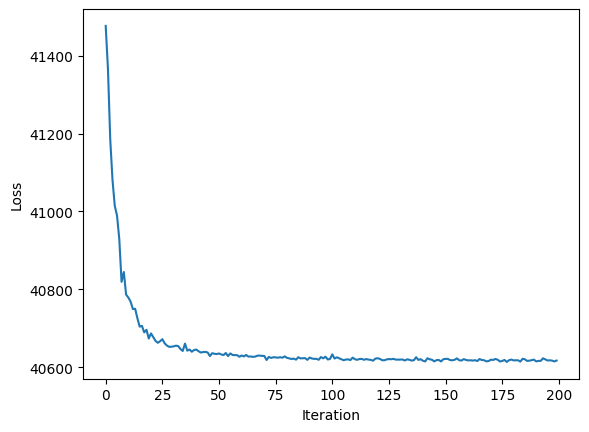

In [16]:
# plot the loss curve with model.losses on the y-axis and range(len(model.losses)) on the x-axis
plt.plot(range(len(model.losses)), model.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Plot pairwise clone VAFs double-check that the correct `wgd_depth` was set.

If two WGD clones have a significant number of SNVs at the top-left or bottom-right corners of the plot (i.e. many clone-specific pre-WGD SNVs), then there were likely two independent WGD events for these clones. Otherwise, it is likely that these two clones diverged after an ancestral (shared) WGD event. For patient `044` shown here, no two clones have a significant number of SNVs at the top-left or bottom-right corners of the plot, so we can be confident that the WGD event happened at the root. Therefore, we are confident that `wgd_depth=0` is the correct setting for this patient.

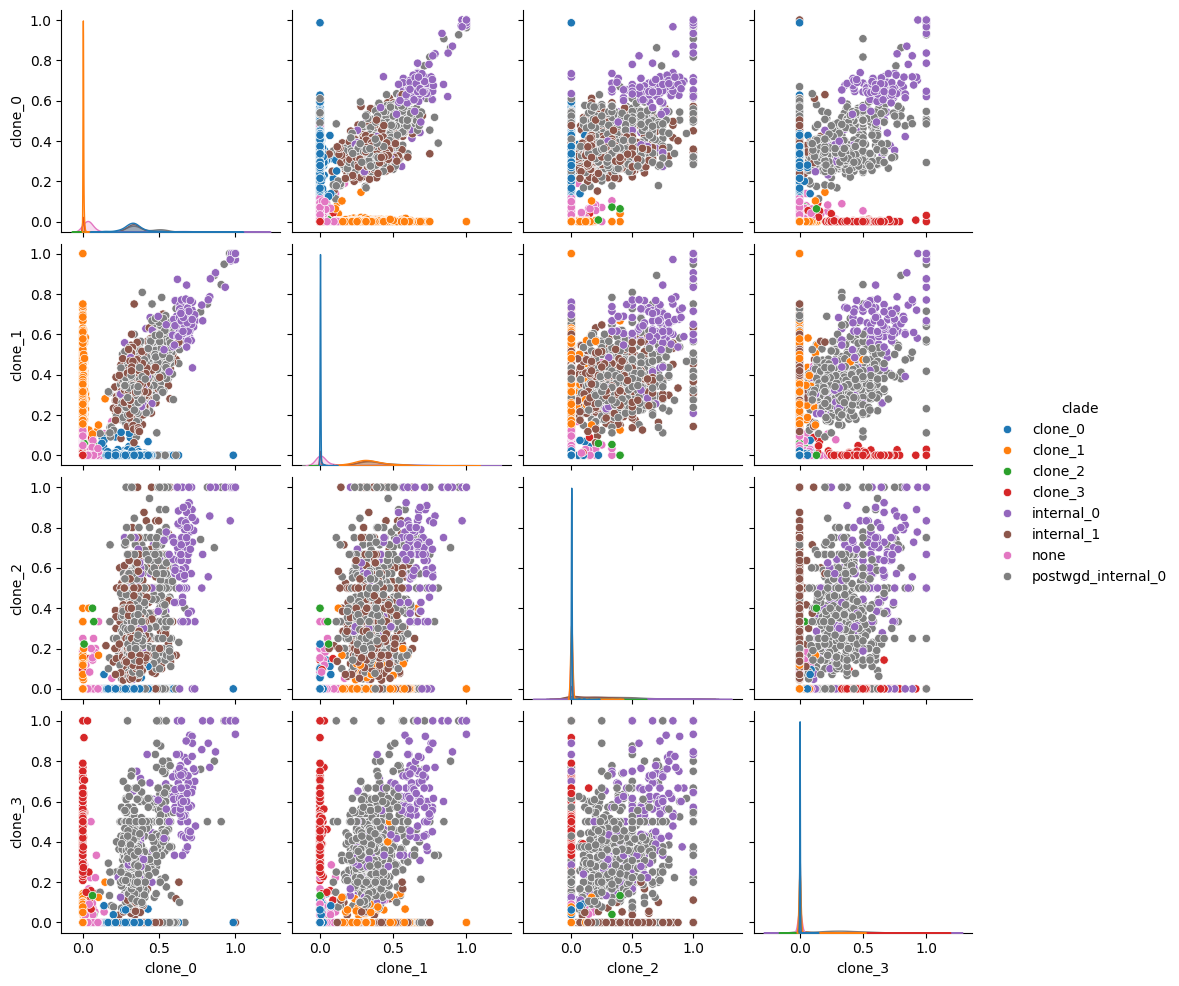

In [17]:
# plot the pairwise VAF
g = dt.pl.plot_clone_pairwise_vaf(data)
plt.show()

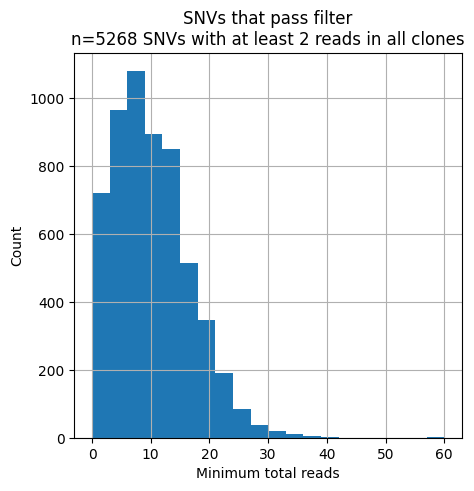

In [18]:
# plot the SNV reads histogram
fig, ax = dt.pl.plot_snv_reads_hist(adata)
plt.show()

Filter the SNV anndata object to include only SNVs with at least 2 reads of suppport in all clones.

In [19]:
# filter the SNVs according to the minimum total count
adata = adata[:, adata.var['min_total_count'] >= 2]

# filter adata based on tree
clones = []
for leaf in tree.get_terminals():
    clones.append(leaf.name.replace('clone_', '').replace('postwgd_', ''))
adata = adata[clones].copy()

# find the SNV types included in the tree
# note that this might differ from snv_types at the time of model initialization
# since we have filtered out SNVs with insufficient total counts
snv_types = sorted(data.ascn.unique())

print(clones)
adata

['0', '1', '2', '3']


AnnData object with n_obs × n_vars = 4 × 5268
    obs: 'cluster_size'
    var: 'chromosome', 'position', 'ref', 'alt', 'block_assignment', 'mean_cell_block_ari', 'mean_snv_block_ari', 'cn_bin', 'snv_type', 'is_homogenous_cn', 'min_total_count'
    layers: 'alt', 'ref', 'Maj', 'Min', 'state', 'vaf', 'ref_count', 'alt_count', 'total_count'

Plot the doubleTime inferred tree.

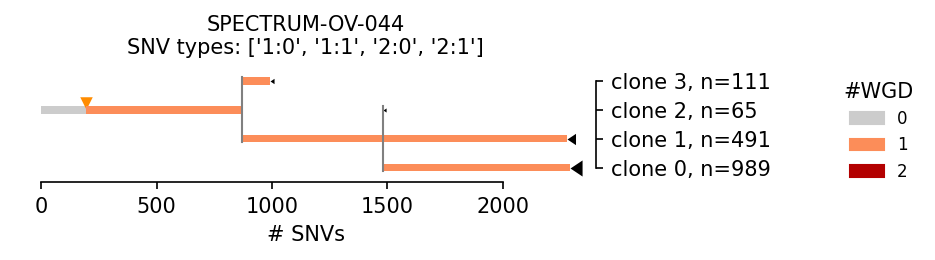

In [20]:
## Plot the tree with the branch lengths annotated by the number of SNVs
## and WGD events represented by color
# compute the number of cells assigned to each clone
cell_counts = dt.tl.compute_clone_cell_counts(adata, tree)
# compute the branch lengths of each clade
branch_lengths = dt.tl.compute_branch_lengths(data, tree, cell_counts)

# draw a doubleTime tree using all SNV counts as branch lengths
ax = dt.pl.plot_clone_tree(tree, branch_lengths, cell_counts)
ax.set_title(f'{patient_id}\nSNV types: {snv_types}', fontsize=10)
plt.show()

Plot the doubleTime inferred tree but this time only include C>T CpG SNVs.

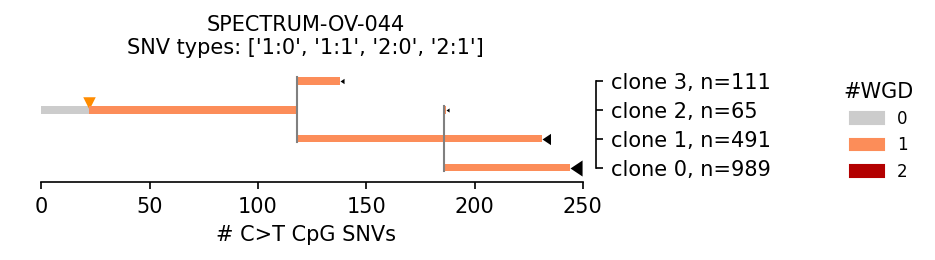

In [21]:
## Plot the tree with the branch lengths annotated by the number of CpG SNVs
cpg_tree = deepcopy(tree)
# compute the branch lengths of each clade based on CpG SNVs
branch_lengths_cpg = dt.tl.compute_branch_lengths(data, cpg_tree, cell_counts, CpG=True)
# draw a doubleTime tree using CpG SNV counts as branch lengths
ax = dt.pl.plot_clone_tree(cpg_tree, branch_lengths_cpg, cell_counts)
ax.set_xlabel('# C>T CpG SNVs')
ax.set_title(f'{patient_id}\nSNV types: {snv_types}', fontsize=10)
plt.show()

Plot the doubleTime inferred tree but this time color each branch according to its fraction of APOBEC C>T mutations rather than the fraction of pre- vs post-WGD mutations. The timing of the WGD event is still annotated on the tree using an orange triange.

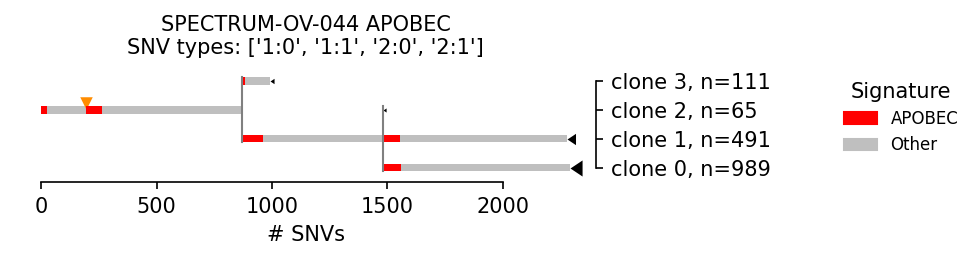

In [22]:
# compute the fraction of ABOPEC SNVs in each clade
apobec_fraction = dt.tl.compute_clade_apobec_fraction(data)

# plot the tree with branch lengths annotated by APOBEC fraction
ax = dt.pl.plot_clone_tree(tree, branch_lengths, cell_counts, apobec_fraction=apobec_fraction)
ax.set_title(f'{patient_id} APOBEC\nSNV types: {snv_types}', fontsize=10)
plt.show()

### SPECTRUM patient `025`

This sample is showcased to demonstrate an example where the `wgd_depth` is set to 1 since there are multiple independent WGD events.

In [23]:
patient_id = 'SPECTRUM-OV-025'
snv_adata_filename = f'demo/input/{patient_id}_demo_snv.h5'
cna_adata_filename = f'demo/input/{patient_id}_demo_cna.h5'
tree_filename = f'demo/output/{patient_id}_tree.pickle'

### Preprocessing

In [24]:
# load input data that comes from running SBMclone
adata = ad.read_h5ad(cna_adata_filename)
adata.obs['haploid_depth'] = adata.obs['coverage_depth'] / adata.obs['ploidy']
snv_adata = ad.read_h5ad(snv_adata_filename)

# in the snakemake pipeline, the tree file is generated by the script `scripts/build_tree.py`
# using snv_adata; however, we are loading it here instead of re-running this first step
tree = pickle.load(open(tree_filename, 'rb'))

# make sure the CN adata and SNV adata have the same cells
adata = adata[snv_adata.obs.index]

# merge the sbmclone_cluster_id from the SNV adata into the CN adata
adata.obs = adata.obs.merge(snv_adata.obs[['sbmclone_cluster_id']], left_index=True, right_index=True, how='left')
assert not adata.obs['sbmclone_cluster_id'].isnull().any()

Preprocess the CN anndata object, the tree object, and the SNV anndata object.

In [25]:
# Aggregate the CN anndata to go from cell x bin to clone x bin, filtering out clones with too few bins
# and SNVs that are incompatible with the doubleTime model (i.e. incorrect ASCN state or ASCN not homogenous within a clone)
adata_cn_clusters, tree, block2leaf = dt.pp.preprocess_cn_adata(adata, tree, min_clone_size=20)

# Manually add WGD events to the tree
# Here, I'm setting wgd_depth=1 to add independent WGD events which are placed
# 1 generation below the root of the tree
dt.pp.add_wgd_tree(tree, adata_cn_clusters, wgd_depth=1)

# split branches with a WGD event into two branches
dt.pp.split_wgd_branches(tree)

# Recursively add n_wgd to each clade
dt.pp.count_wgd(tree.clade, 0)

# Make sure that the SNV adata has the same cells as the CN adata
snv_adata = snv_adata[adata.obs.index]

# Aggregate the SNV cell x snv anndata to a clone x snv anndata with the same rows and columns
# as adata_cn_clusters, adding the appropriate layers, obs and var for running the doubleTime model
adata_clusters = dt.pp.preprocess_snv_adata(snv_adata, adata_cn_clusters, block2leaf)

/data1/shahs3/users/weinera2/doubleTime/doubletime/preprocessing/_preprocessing.py:71: ImplicitModificationWarning: Setting element `.layers['clone_median_state']` of view, initializing view as actual.
  adata.layers[f'clone_median_{layer}'] = adata_cn_clusters.to_df(layer).loc[adata.obs['leaf_id'].values, :]
/data1/shahs3/users/weinera2/doubleTime/doubletime/preprocessing/_preprocessing.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  snv_adata.obs['leaf_id'] = snv_adata.obs.sbmclone_cluster_id.map(block2leaf)
/data1/shahs3/users/weinera2/doubleTime/doubletime/preprocessing/_preprocessing.py:176: RuntimeWarning: invalid value encountered in divide
  adata_clusters.layers['vaf'] = adata_clusters.layers['alt'] / (adata_clusters.layers['ref'] + adata_clusters.layers['alt'])


In [26]:
adata = adata_clusters

In [27]:
# Remove non-homogenous snvs and make sure there are still SNVs left
adata = adata[:, adata.var['is_homogenous_cn']].copy()
if np.min(adata.shape) == 0:
    print("Anndata has 0 clones or SNVs, shape=", adata.shape)

### Running the model

In [28]:
# set model hyperparameters
min_total_counts_perblock = 2
cnloh_only = False

if cnloh_only:
    snv_types = ['2:0']
else:
    snv_types = ['1:0', '1:1', '2:0', '2:1', '2:2']

# initialize the model object using adata & tree
model = dt.ml.doubleTimeModel(adata, tree, snv_types=snv_types, min_total_counts_perblock=min_total_counts_perblock)

# train the model and get the model trace
model.train()
model.get_model_trace()

# get the model output and save it to a csv file
genome_fasta_filename = '/data1/shahs3/users/myersm2/reference/grch37/GRCh37-lite.fa'
data = model.format_model_output(ref_genome=genome_fasta_filename)

Number of SNVs with at least 2 reads in all clones: 8181
Initial loss: 25884.716796875
Final loss: 24164.421875


### Plotting model output

Plot loss curve to make sure that the model converged.

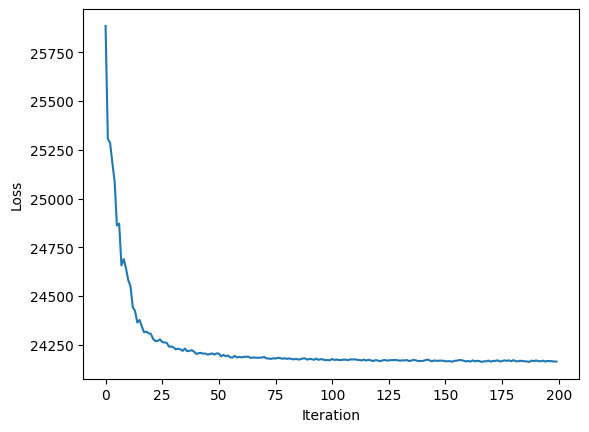

In [29]:
# plot the loss curve with model.losses on the y-axis and range(len(model.losses)) on the x-axis
plt.plot(range(len(model.losses)), model.losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Plot pairwise clone VAFs double-check that the correct `wgd_depth` was set.

If two WGD clones have a significant number of SNVs at the top-left or bottom-right corners of the plot (i.e. many clone-specific pre-WGD SNVs), then there were likely two independent WGD events for these clones. Otherwise, it is likely that these two clones diverged after an ancestral (shared) WGD event. 

For patient `025` shown here, we see a significant number of clone-specific pre-WGD SNVs at the top-left and bottom-right corners of the scatterplots comparing `clone_3` to `clone_0` and `clone_1`. However, we do not see an accumulation at these two corners when comparing `clone_0` to `clone_1`. This suggests that there were two independent WGD events that arose after clone 3 diverged from clones 0 and 1: one WGD event that was exclusive to clone 3, and a separate WGD event on the shared internal branch of clones 0 and 1. Therefore, we are confident that `wgd_depth=1` is the correct setting for this patient.

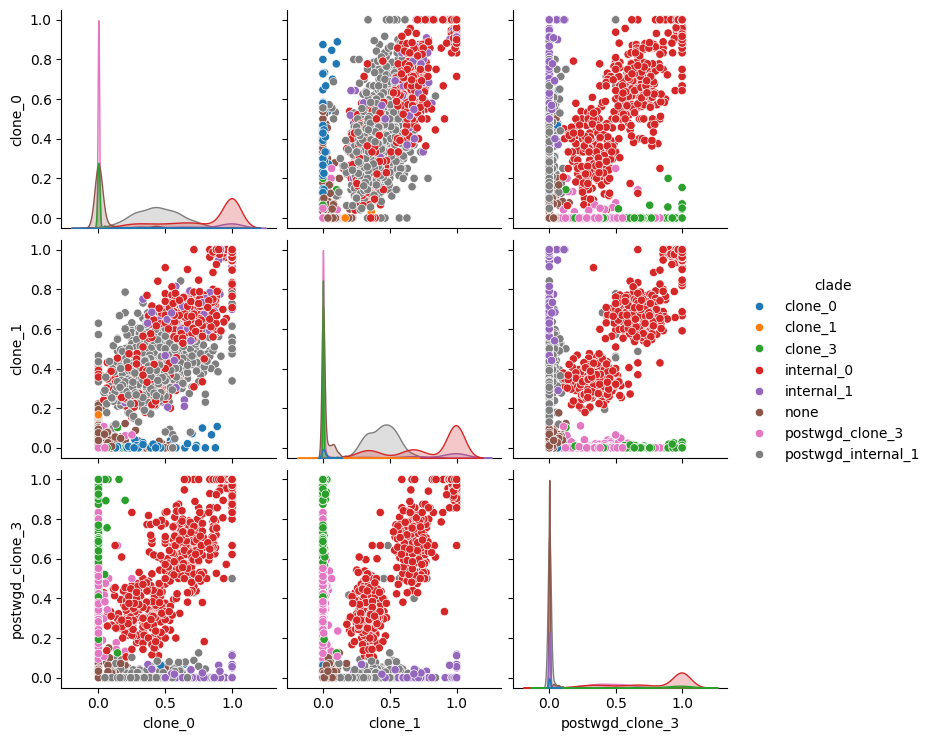

In [30]:
# plot the pairwise VAF
g = dt.pl.plot_clone_pairwise_vaf(data)
plt.show()

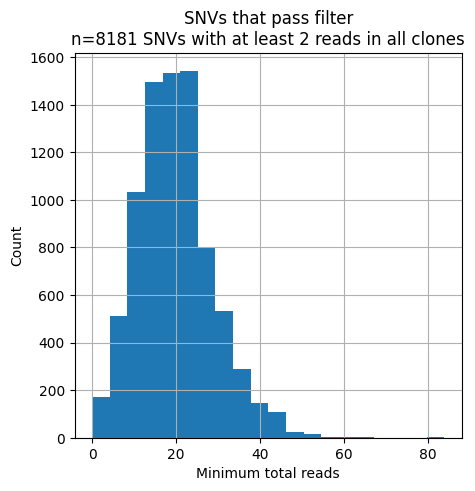

In [31]:
# plot the SNV reads histogram
fig, ax = dt.pl.plot_snv_reads_hist(adata)
plt.show()

Filter the SNV anndata object to include only SNVs with at least 2 reads of suppport in all clones.

In [32]:
# filter the SNVs according to the minimum total count
adata = adata[:, adata.var['min_total_count'] >= 2]

# filter adata based on tree
clones = []
for leaf in tree.get_terminals():
    clones.append(leaf.name.replace('clone_', '').replace('postwgd_', ''))
adata = adata[clones].copy()

# find the SNV types included in the tree
# note that this might differ from snv_types at the time of model initialization
# since we have filtered out SNVs with insufficient total counts
snv_types = sorted(data.ascn.unique())

print(clones)
adata

['0', '1', '3']


AnnData object with n_obs × n_vars = 3 × 8181
    obs: 'cluster_size'
    var: 'chromosome', 'position', 'ref', 'alt', 'block_assignment', 'mean_cell_block_ari', 'mean_snv_block_ari', 'cn_bin', 'snv_type', 'is_homogenous_cn', 'min_total_count'
    layers: 'alt', 'ref', 'Maj', 'Min', 'state', 'vaf', 'ref_count', 'alt_count', 'total_count'

Plot the doubleTime inferred trees, coloring branches by both WGD and APOBEC status and scaling the x-axis both by the total number of SNVs or only by the number of C>T CpG SNVs.

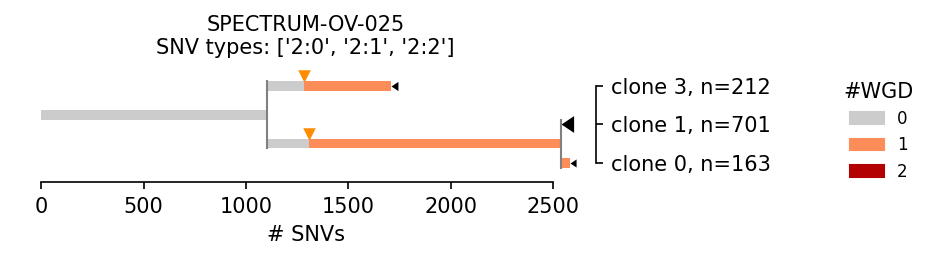

In [33]:
## Plot the tree with the branch lengths annotated by the number of SNVs
## and WGD events represented by color
# compute the number of cells assigned to each clone
cell_counts = dt.tl.compute_clone_cell_counts(adata, tree)
# compute the branch lengths of each clade
branch_lengths = dt.tl.compute_branch_lengths(data, tree, cell_counts)

# draw a doubleTime tree using all SNV counts as branch lengths
ax = dt.pl.plot_clone_tree(tree, branch_lengths, cell_counts)
ax.set_title(f'{patient_id}\nSNV types: {snv_types}', fontsize=10)
plt.show()

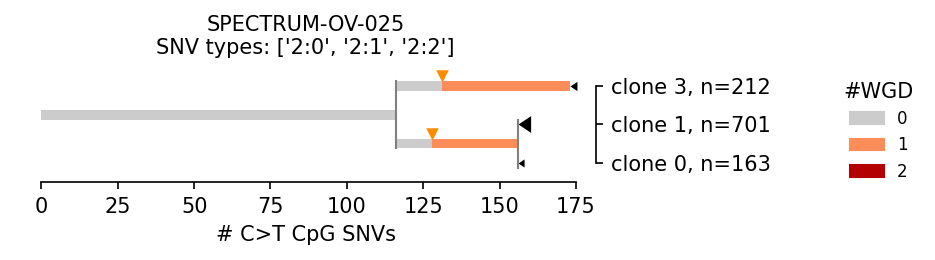

In [34]:
## Plot the tree with the branch lengths annotated by the number of CpG SNVs
cpg_tree = deepcopy(tree)
# compute the branch lengths of each clade based on CpG SNVs
branch_lengths_cpg = dt.tl.compute_branch_lengths(data, cpg_tree, cell_counts, CpG=True)
# draw a doubleTime tree using CpG SNV counts as branch lengths
ax = dt.pl.plot_clone_tree(cpg_tree, branch_lengths_cpg, cell_counts)
ax.set_xlabel('# C>T CpG SNVs')
ax.set_title(f'{patient_id}\nSNV types: {snv_types}', fontsize=10)
plt.show()

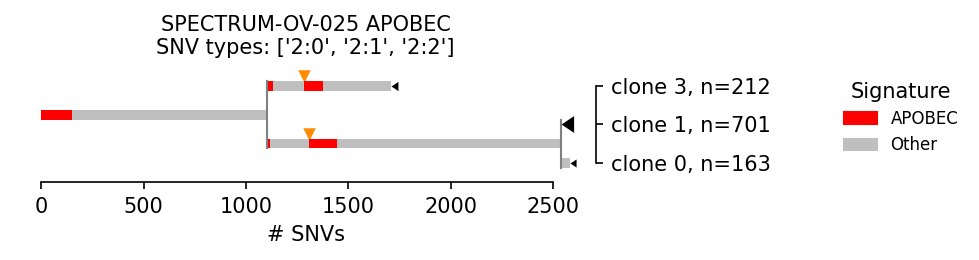

In [35]:
# compute the fraction of ABOPEC SNVs in each clade
apobec_fraction = dt.tl.compute_clade_apobec_fraction(data)

# plot the tree with branch lengths annotated by APOBEC fraction
ax = dt.pl.plot_clone_tree(tree, branch_lengths, cell_counts, apobec_fraction=apobec_fraction)
ax.set_title(f'{patient_id} APOBEC\nSNV types: {snv_types}', fontsize=10)
plt.show()